### Imports

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

import torch
from transformers import LlamaForCausalLM, AutoTokenizer

from dicl import dicl

/home/abenechehab/miniconda3/envs/DICL/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load LLM model and tokenizer

* The tokenizers that are supported are those who assign a separate token to each number between 0 and 999. This includes Llama 3, Llama 3.1, and Llama 3.2 families of models.
* You need to have an account on [huggingface](https://huggingface.co/) and request access to the Llama models.

* To load an already downloaded model, change *llm_model* to point to the corresponding snapshot.

In [3]:
llm_model = "/mnt/vdb/hugguingface/hub/models--meta-llama--Llama-3.2-1B/snapshots/5d853ed7d16ac794afa8f5c9c7f59f4e9c950954"

tokenizer = AutoTokenizer.from_pretrained(
    llm_model,
    use_fast=False,
)
model = LlamaForCausalLM.from_pretrained(
    llm_model,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)
model.eval()

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm):

## Load data

* We will be using expert trajectories from the HalfCheetah Mujoco environment for our demo. The dataset is provided in `src/dicl/data/`.

In [7]:
env_name = "HalfCheetah"
n_actions = 6  # number of actions in the HalfCheetah system
n_observations = 17  # number of observations in the HalfCheetah system
data_label = "expert"
data_path = Path("../src") / "dicl" / "data" / f"D4RL_{env_name}_{data_label}.csv"

# ICL parameters
context_length = 300
rescale_factor = 7.0
up_shift = 1.5

* Pick DICL(s) or DICL(s,a) method through the number of features (choose `n_observations` for vICL).

In [8]:
# to use DICL-(s) or vICL, set include_actions to False.
# to use DICL-(s,a), set include_actions to True
include_actions = True
if include_actions:
    n_features = n_observations + n_actions
else:
    n_features = n_observations

* Sample an episode and extract an in-context trajectory `(n_timestamps, n_features)`

In [9]:
# load data to get a sample episode
X = pd.read_csv(data_path, index_col=0)
X = X.values.astype("float")

# find episodes beginnings. the restart column is equal to 1 at the start of
# an episode, 0 otherwise.
restart_index = n_observations + n_actions + 1
restarts = X[:, restart_index]
episode_starts = np.where(restarts)[0]

# sample an episode and extract time series
episode = np.random.choice(episode_starts)
time_series = X[episode : episode + context_length, :n_features]

print(
    f"The in-context trajectory shape is (n_timestamps:{time_series.shape[0]}, "
    f"n_features:{time_series.shape[1]})"
)

The in-context trajectory shape is (n_timestamps:300, n_features:23)


## DICL

* Instantiate DICL
* Choose the number of components for PCA (set to half here)
* Dor vICL n_components has to be equal to n_features

In [10]:
# to use vICL, set vanilla_icl to True.
# to use DICL-(s,a) or DICL-(s), set vanilla_icl to False
vanilla_icl = False
if vanilla_icl:
    DICL = dicl.vICL(
        n_features=n_features,
        model=model,
        tokenizer=tokenizer,
        rescale_factor=rescale_factor,
        up_shift=up_shift,
    )
else:
    DICL = dicl.DICL_PCA(
        n_features=n_features,
        n_components=int(n_features / 2),
        model=model,
        tokenizer=tokenizer,
        rescale_factor=rescale_factor,
        up_shift=up_shift,
    )

* Fit disentangler (PCA here). This can be done using a bigger dataset than the in-context time series.

In [11]:
DICL.fit_disentangler(X=time_series)

### Single-step prediction and visualization

In [15]:
mean, mode, lb, ub = DICL.predict_single_step(X=time_series)

# print metrics
burnin = 0
single_step_metrics = DICL.compute_metrics(burnin=burnin)
print(single_step_metrics.keys())
print(f"after burnin steps: {burnin}")
print(
    "average_agg_squared_error: "
    f"{single_step_metrics['average_agg_squared_error']:.3f}"
)
print(f"agg_ks: {single_step_metrics['agg_ks']}")

dict_keys(['average_agg_squared_error', 'agg_squared_error', 'average_perdim_squared_error', 'perdim_squared_error', 'scaled_average_agg_squared_error', 'scaled_agg_squared_error', 'scaled_average_perdim_squared_error', 'scaled_perdim_squared_error', 'perdim_ks', 'agg_ks'])
after burnin steps: 0
average_agg_squared_error: 13.355
agg_ks: 0.0942663952304784


In [16]:
single_step_metrics["scaled_average_perdim_squared_error"]

array([0.74073731, 0.47111517, 0.20493538, 0.42967662, 0.42043207,
       0.28133781, 0.37676385, 0.66648634, 0.26235554, 0.79828242,
       0.58881039, 0.29228175, 0.39822781, 0.50139812, 0.34389294,
       0.44726202, 0.73420414, 0.4129932 , 0.68332112, 0.50423537,
       0.59341173, 0.53805159, 0.5766872 ])

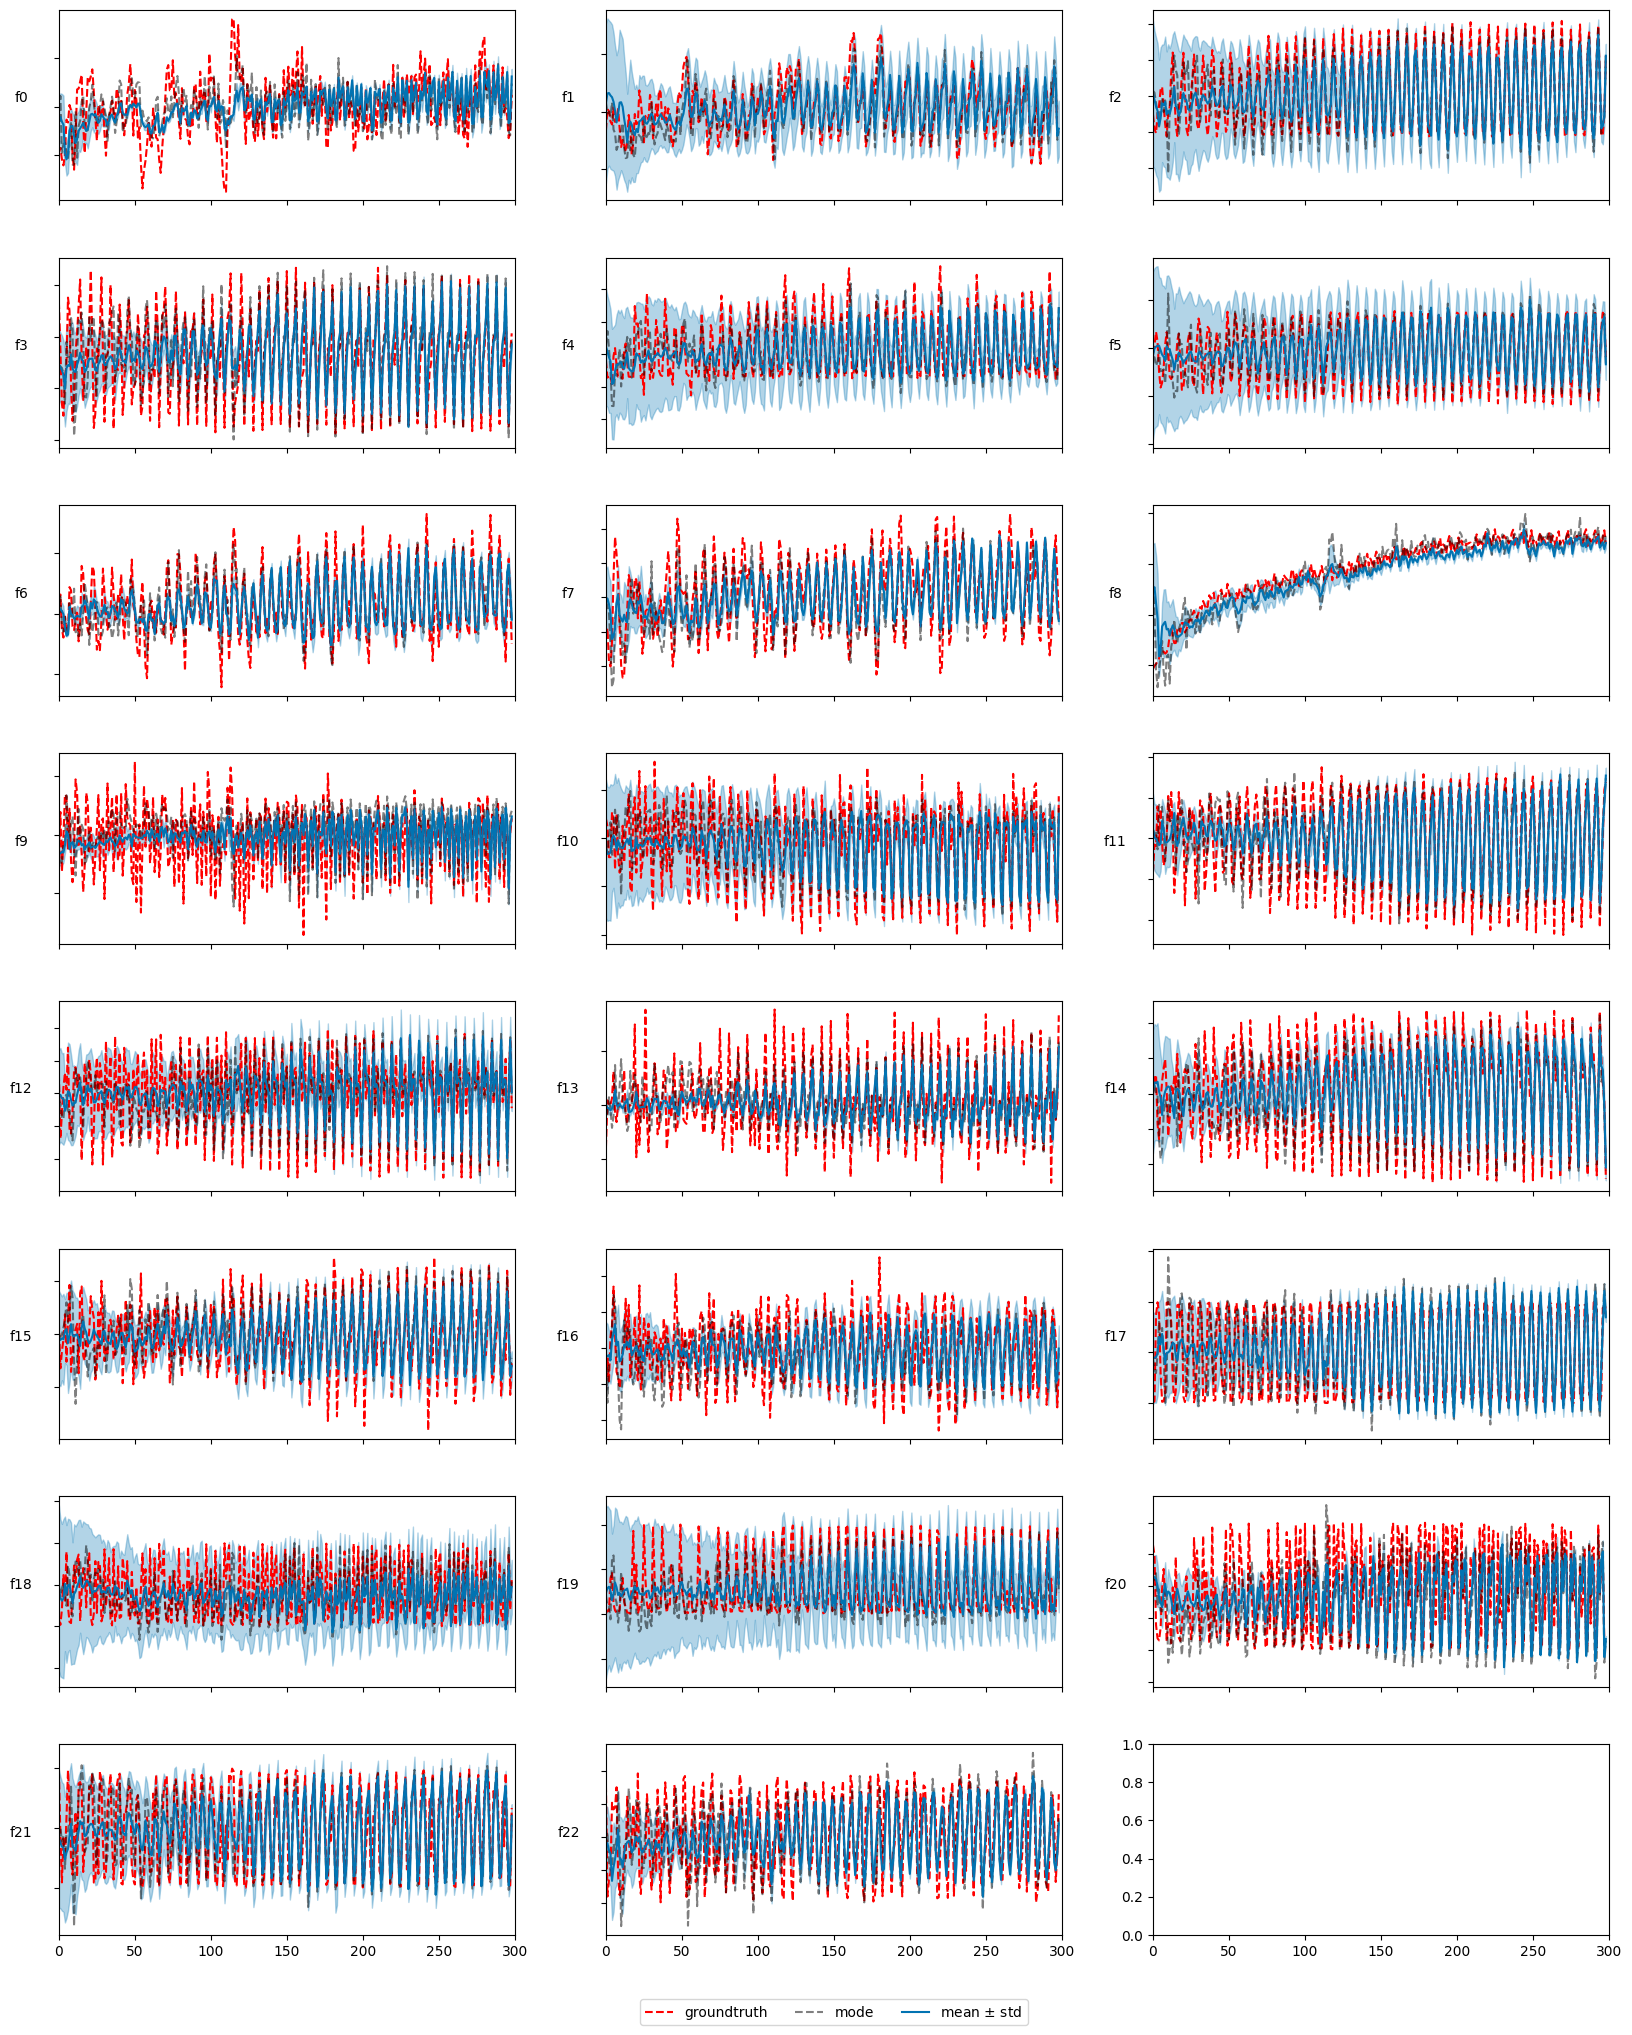

In [10]:
DICL.plot_single_step(xlim=[0, context_length])

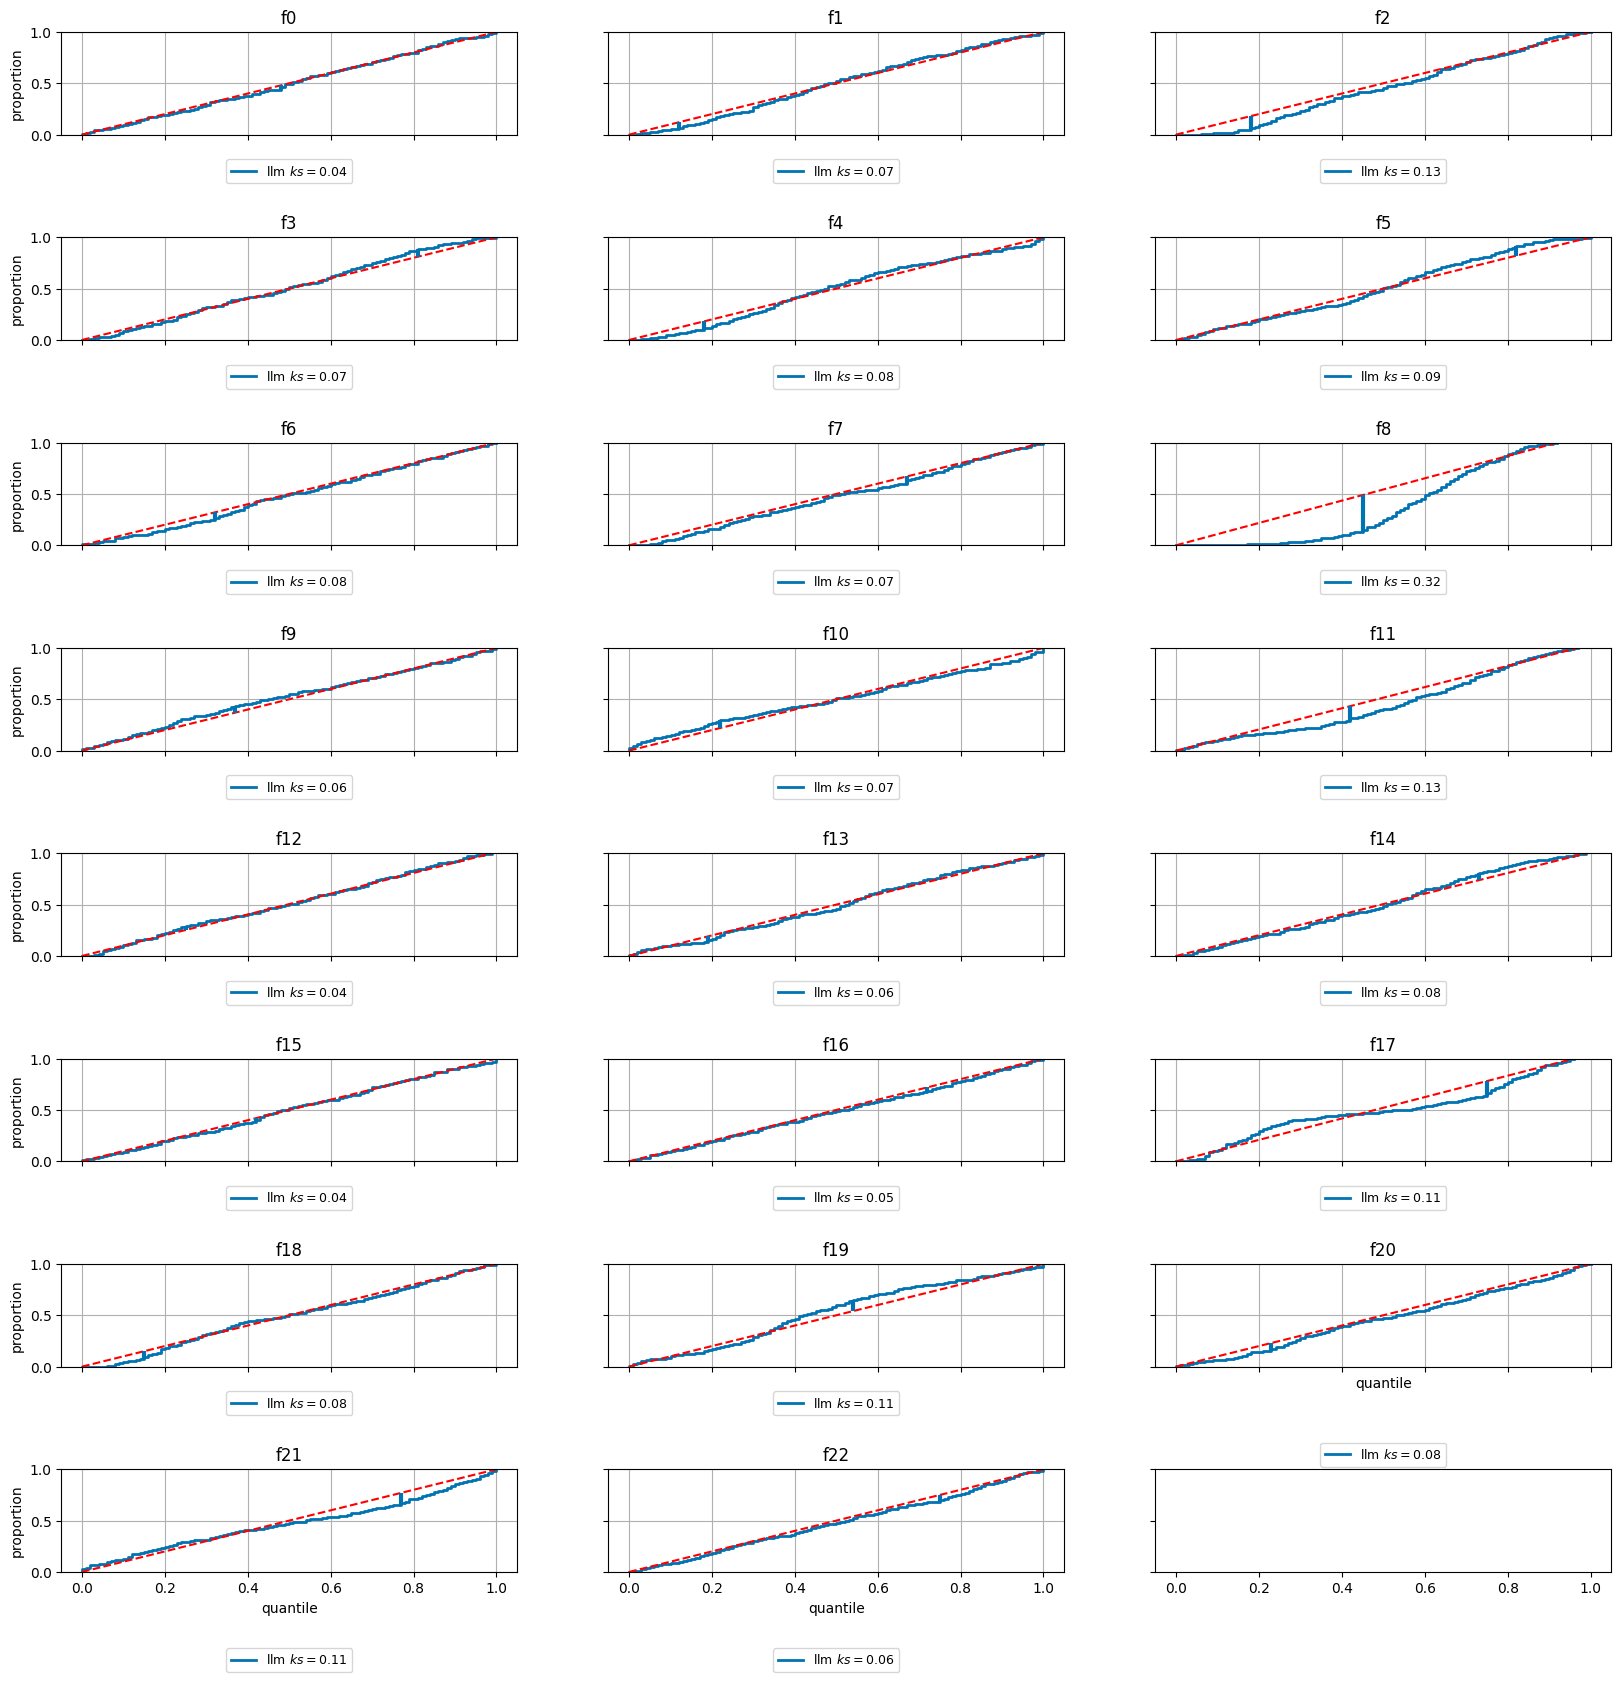

In [11]:
DICL.plot_calibration(burnin=0)

### Autoregressive multi-step prediction and visualization

In [12]:
prediction_horizon = 20
mean, mode, lb, ub = DICL.predict_multi_step(
    X=time_series,
    prediction_horizon=prediction_horizon,
    stochastic=True,
    if_true_mean_else_mode=True,
)

prediction_horizon:   0%|          | 0/20 [00:00<?, ?it/s]

prediction_horizon: 100%|██████████| 20/20 [01:29<00:00,  4.47s/it]


In [13]:
# print metrics
burnin = context_length - prediction_horizon  # only keeps multi-step prediction
single_step_metrics = DICL.compute_metrics(burnin=burnin)
print(f"after burnin steps: {burnin}")
print(
    "average_agg_squared_error: "
    f"{single_step_metrics['average_agg_squared_error']:.3f}"
)
print(f"agg_ks: {single_step_metrics['agg_ks']}")

after burnin steps: 280
average_agg_squared_error: 19.836
agg_ks: 0.3455148741418764


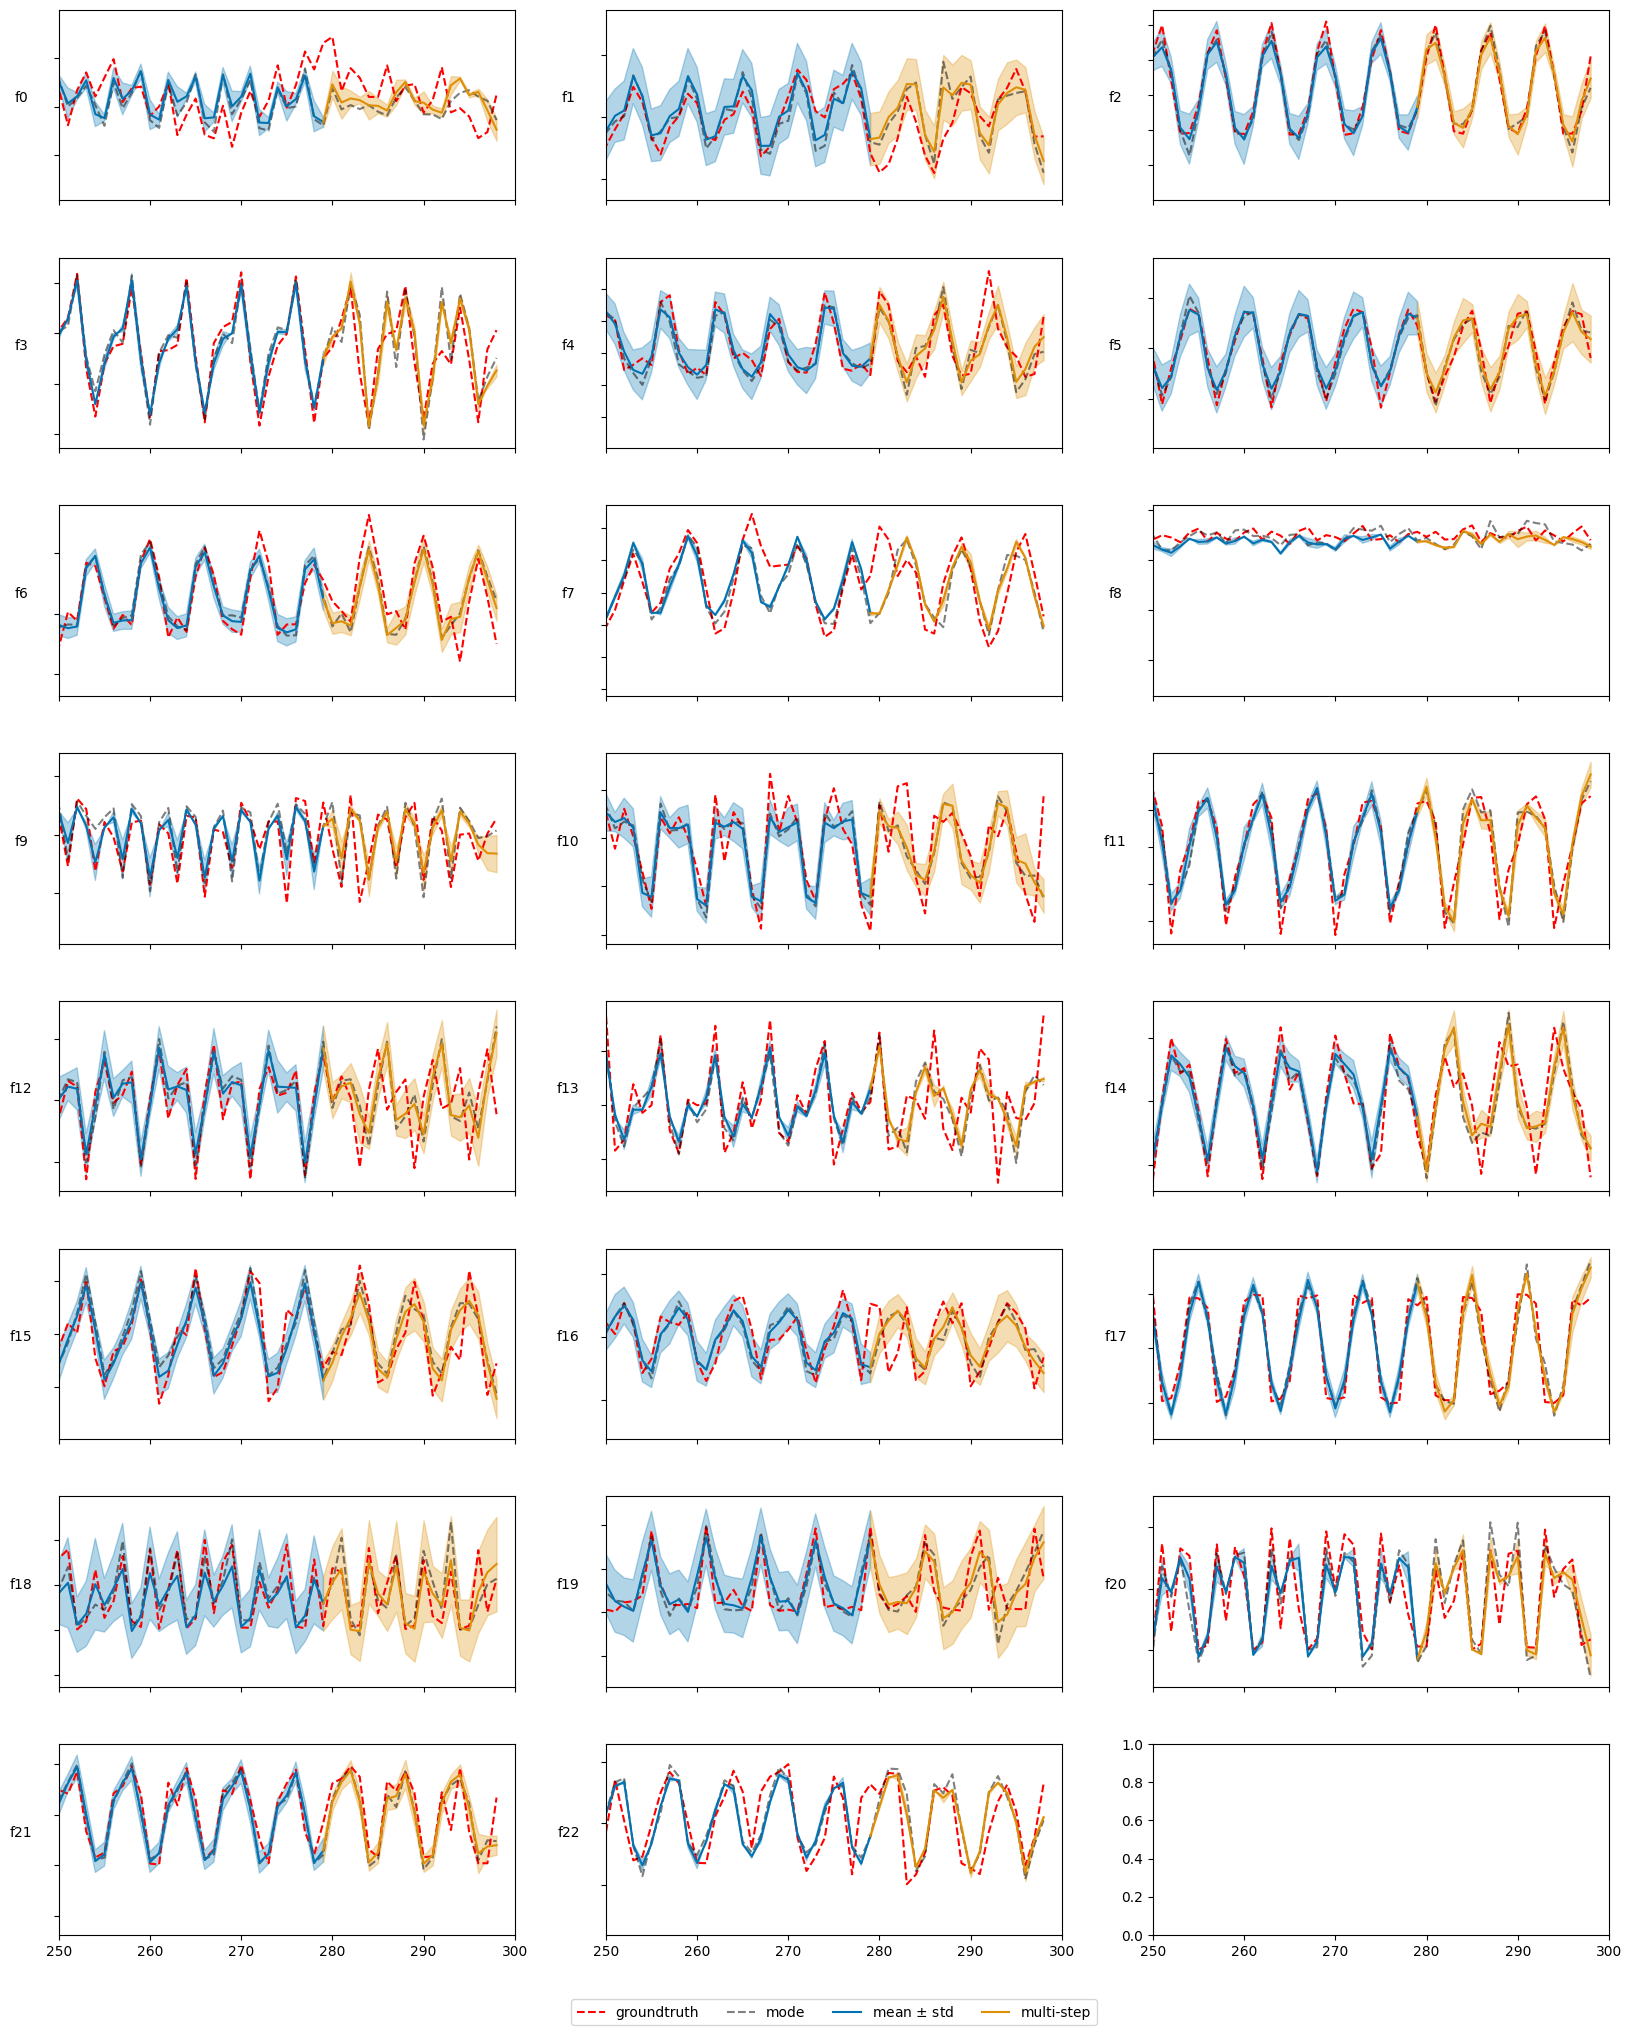

In [14]:
DICL.plot_multi_step(xlim=[context_length - 50, context_length])